<h1 align = "center">Grad Class Activation Map</h1>

In [1]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as T
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam
from matplotlib import pyplot as plt

import models


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
transform_test = T.Compose(
    [T.ToTensor(), T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]
)
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)
test_batch_size = 256
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=test_batch_size, shuffle=False, num_workers=2
)


Files already downloaded and verified


In [4]:
net = models.ResNet18()
if device == 'cuda':
    net = nn.DataParallel(net)
    cudnn.benchmark = True
checkpoint = torch.load('./checkpoints/checkpoint_resnet18.pth')
net.load_state_dict(checkpoint["net"])
net = net.module


In [5]:
def grad_cam(img, model, layer):
    configs = [dict(model_type='resnet', arch=model, layer_name=layer)]

    for config in configs:
        config['arch'].to(device).eval()

    torch_img = T.Compose([T.ToTensor()])(img).to(device)
    normed_torch_img = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(
        torch_img
    )[None]

    cams = [
        [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
        for config in configs
    ]

    images = []
    for gradcam, gradcam_pp in cams:
        mask, _ = gradcam(normed_torch_img)
        heatmap, result = visualize_cam(mask, torch_img)

        mask_pp, _ = gradcam_pp(normed_torch_img)
        heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

        images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

    return images


In [6]:
classes = (
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
)


(-0.5, 31.5, 31.5, -0.5)

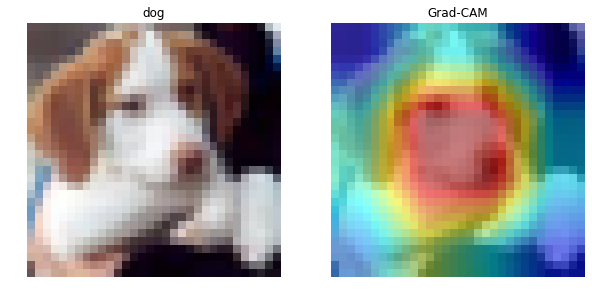

In [7]:
idx = 16
img = test_set.data[idx]
label = test_set[idx][1]
layer = 'layer4'

cam = grad_cam(img, net, layer)
cam = torch.stack(cam)[4]
cam = np.transpose(cam, (1, 2, 0))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'{classes[label]}')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cam)
plt.title(f'Grad-CAM')
plt.axis('off')
